# 0.0 IMPORTS

In [48]:
import pandas as pd
import inflection
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from tabulate import tabulate
from scipy import stats as ss
from IPython.display import Image
import datetime
import warnings
import os
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x,y):
    
    cm = pd.crosstab(x, y).values#converting into a matrix
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2_corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_corr = k - ((k-1)**2)/(n-1)
    r_corr = r - ((r-1)**2)/(n-1)
    
    v = np.sqrt((chi2_corr/n) / (min(k_corr-1, r_corr-1)) )
    return v


def settings():
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=21,12
    plt.rcParams['font.size']=24
    
    warnings.filterwarnings('ignore')#to ignore that we're dividing by zero
    
    sns.set()

In [3]:
settings()

## 0.2 Loading Data

In [4]:
path_1 = 'C:\\Users\\joaoa\\Documents\\DSprojects\\Git\\repos\\DataScience_Em_Producao\\data\\train.csv'
path_2 = 'C:\\Users\\joaoa\\Documents\\DSprojects\\Git\\repos\\DataScience_Em_Producao\\data\\store.csv'

df_sales_raw = pd.read_csv(path_1, low_memory=False)
df_store_raw = pd.read_csv(path_2, low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
240519,474,6,2014-12-27,6783,710,1,0,0,0,c,a,14810.0,NaN,NaN,1,14.0,2011.0,"Mar,Jun,Sept,Dec"


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
#make a copy
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Colums: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Colums: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance (200000.0 as it was no competition) 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_yea
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                          
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] is x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.sample(5).T

,602519,518827,980602,205605,606742
store,90,23,188,446,968
day_of_week,2,7,6,3,6
date,2014-01-07 00:00:00,2014-03-23 00:00:00,2013-02-02 00:00:00,2015-01-28 00:00:00,2014-01-04 00:00:00
sales,10358,0,4953,5097,4785
customers,1284,0,475,634,604
open,1,0,1,1,1
promo,1,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,d,d,a,c


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types

In [14]:
#turning into int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


#merge
M = pd.concat([d3,d2,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
M.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
M

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,200000.0,20.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

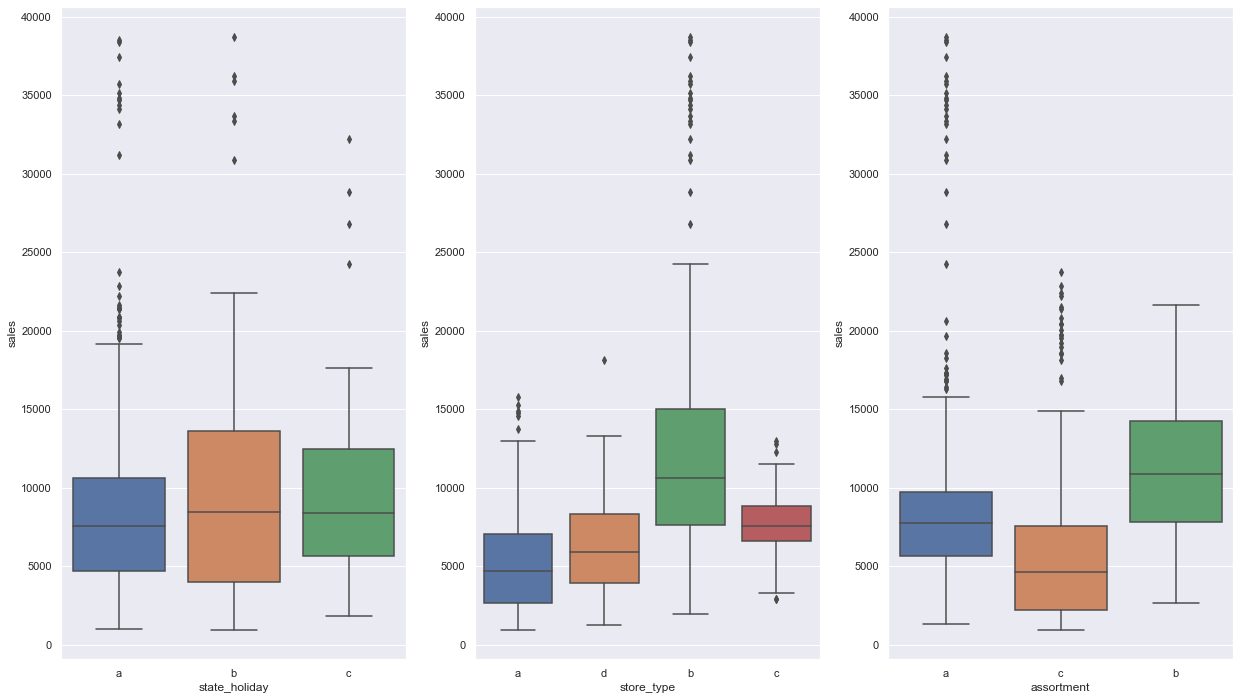

In [18]:
#filtering
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#plot
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1);

# 2.0 FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## Mind Map of Hypothesis

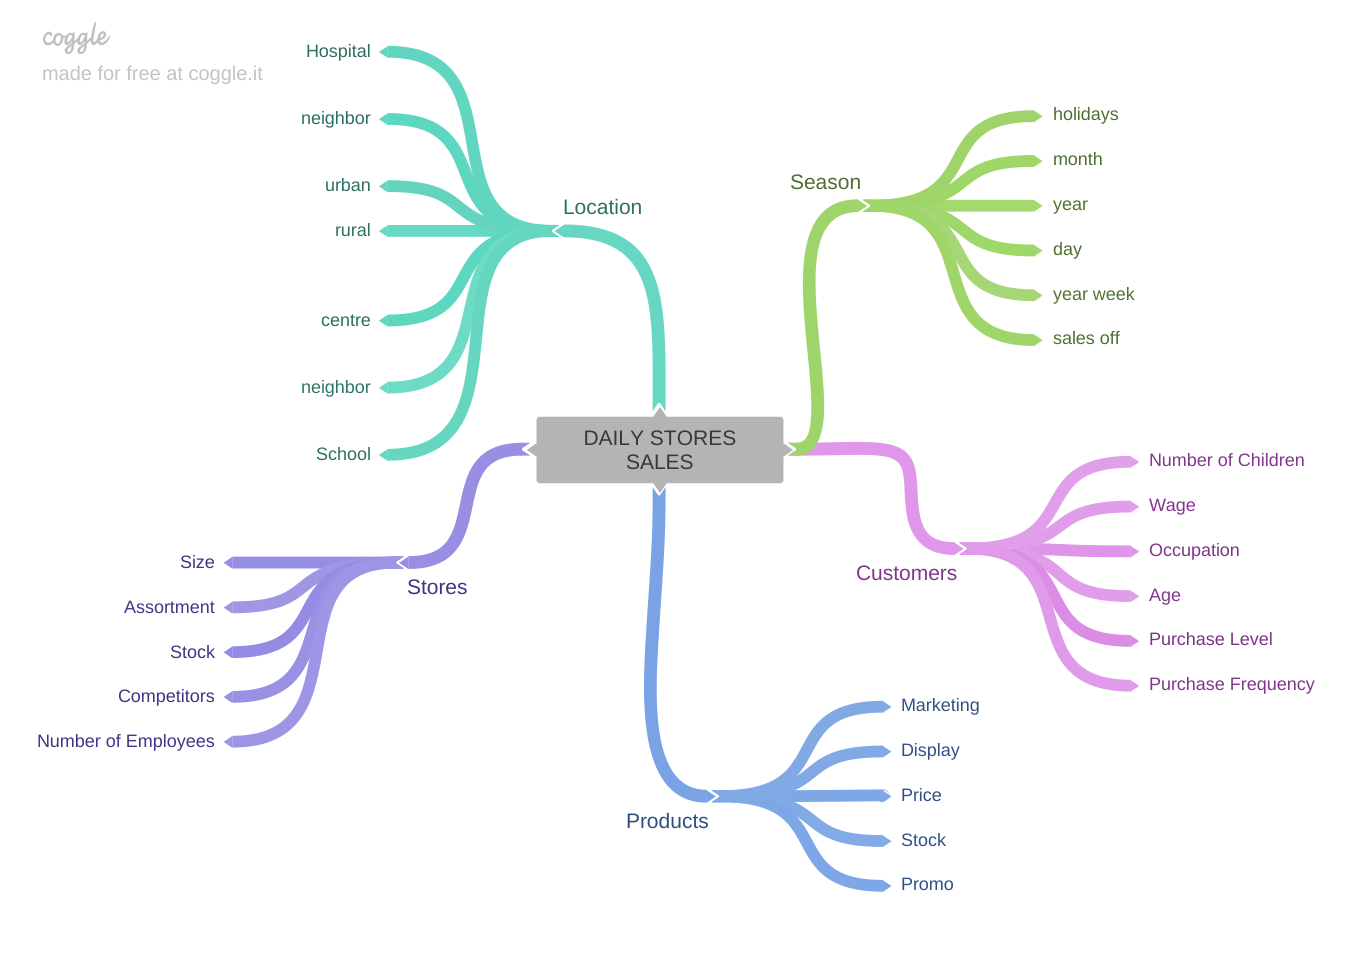

In [19]:
Image('C:\\Users\\joaoa\\Documents\\DSprojects\\Git\\repos\\DataScience_Em_Producao\MindMapHypothesis.png')

## 2.1 Hypothesis creation

### 2.1.1 Store Hypothesis

**1. Stores with more employees sell more** 

**2. Stores with bigger stock sell more** 

**3. Larger Stores sell more**

**4. Stores with bigger assortment sell more** 

**5. Stores with closer competitors sell less** 

**6. Stores with competitors for longer sell more** 

### 2.1.2 Products Hypothesis

**1. Stores with bigger investment in Marketing sell more**

**2. Stores that display more their products sell more** 

**3. Stores with cheaper products sell more**

**4. Stores with bigger discounts on their promos sell more** 

**5. Stores with promo for longer sell more**

**6. Stores with more days of promo sell more** 

**7. Stores with more consecutive promo sell more** 

### 2.1.3 Time Hypothesis

**1. Stores open at Chrismas sell more** 

**2. Stores sell more within the years** 

**3. Stores sell more in the second semester**

**4. Stores sell more after day 10th of the month** 

**5. Stores sell less on weekends** 

**6. Stores sell less on school holidays**

## 2.2 Final list of Hypothesis

**1. Stores with bigger assortment sell more** 

**2. Stores with closer competitors sell less** 

**3. Stores with competitors for longer sell more**

**4. Stores with promo for longer sell more**

**5. Stores with more days of promo sell more** 

**6. Stores with more consecutive promo sell more** 

**7. Stores open at Chrismas sell more** 

**8. Stores sell more within the years** 

**9. Stores sell more in the second semester**

**10. Stores sell more after day 10th of the month** 

**11. Stores sell less on weekends** 

**12. Stores sell less on school holidays**

## 2.3 Feature Engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('Y%-W%')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLES' FILTRATION

In [22]:
df3 = df2.copy()

## 3.1 Rows' Filtration

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] != 0)]

## 3.2 Columns' Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

KeyError: "['customers' 'open' 'promo_interval' 'month_map'] not found in axis"

# 4.0 EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variables

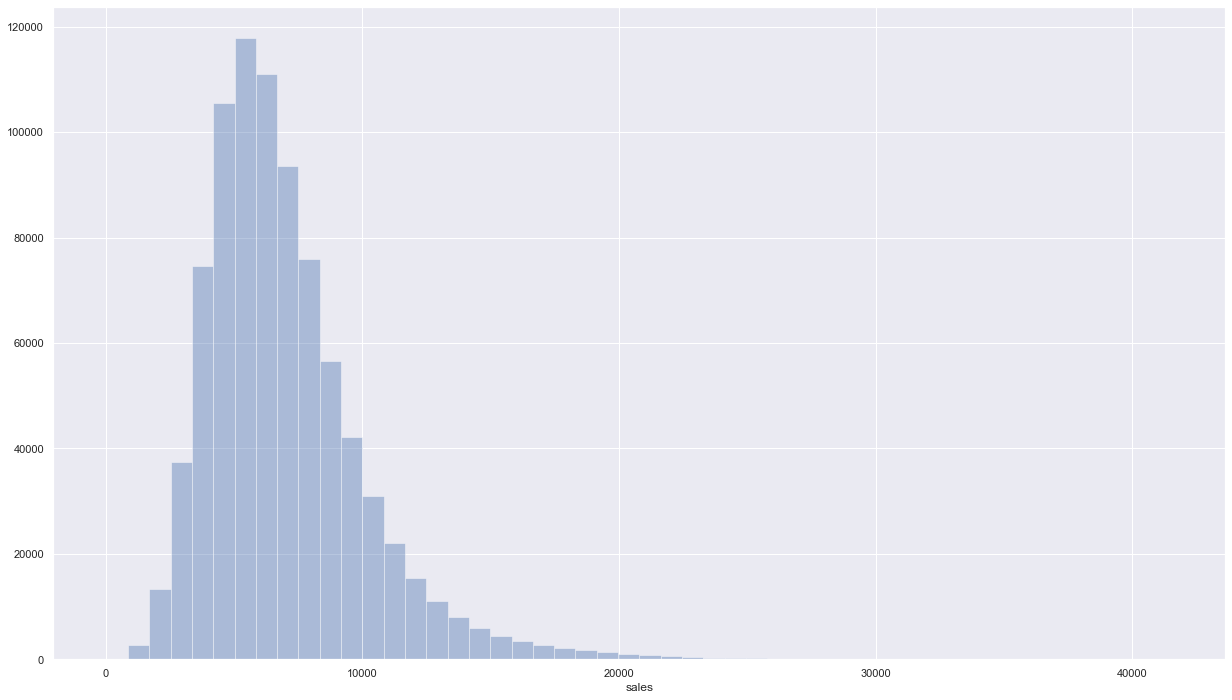

In [27]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2 Numeric Variables

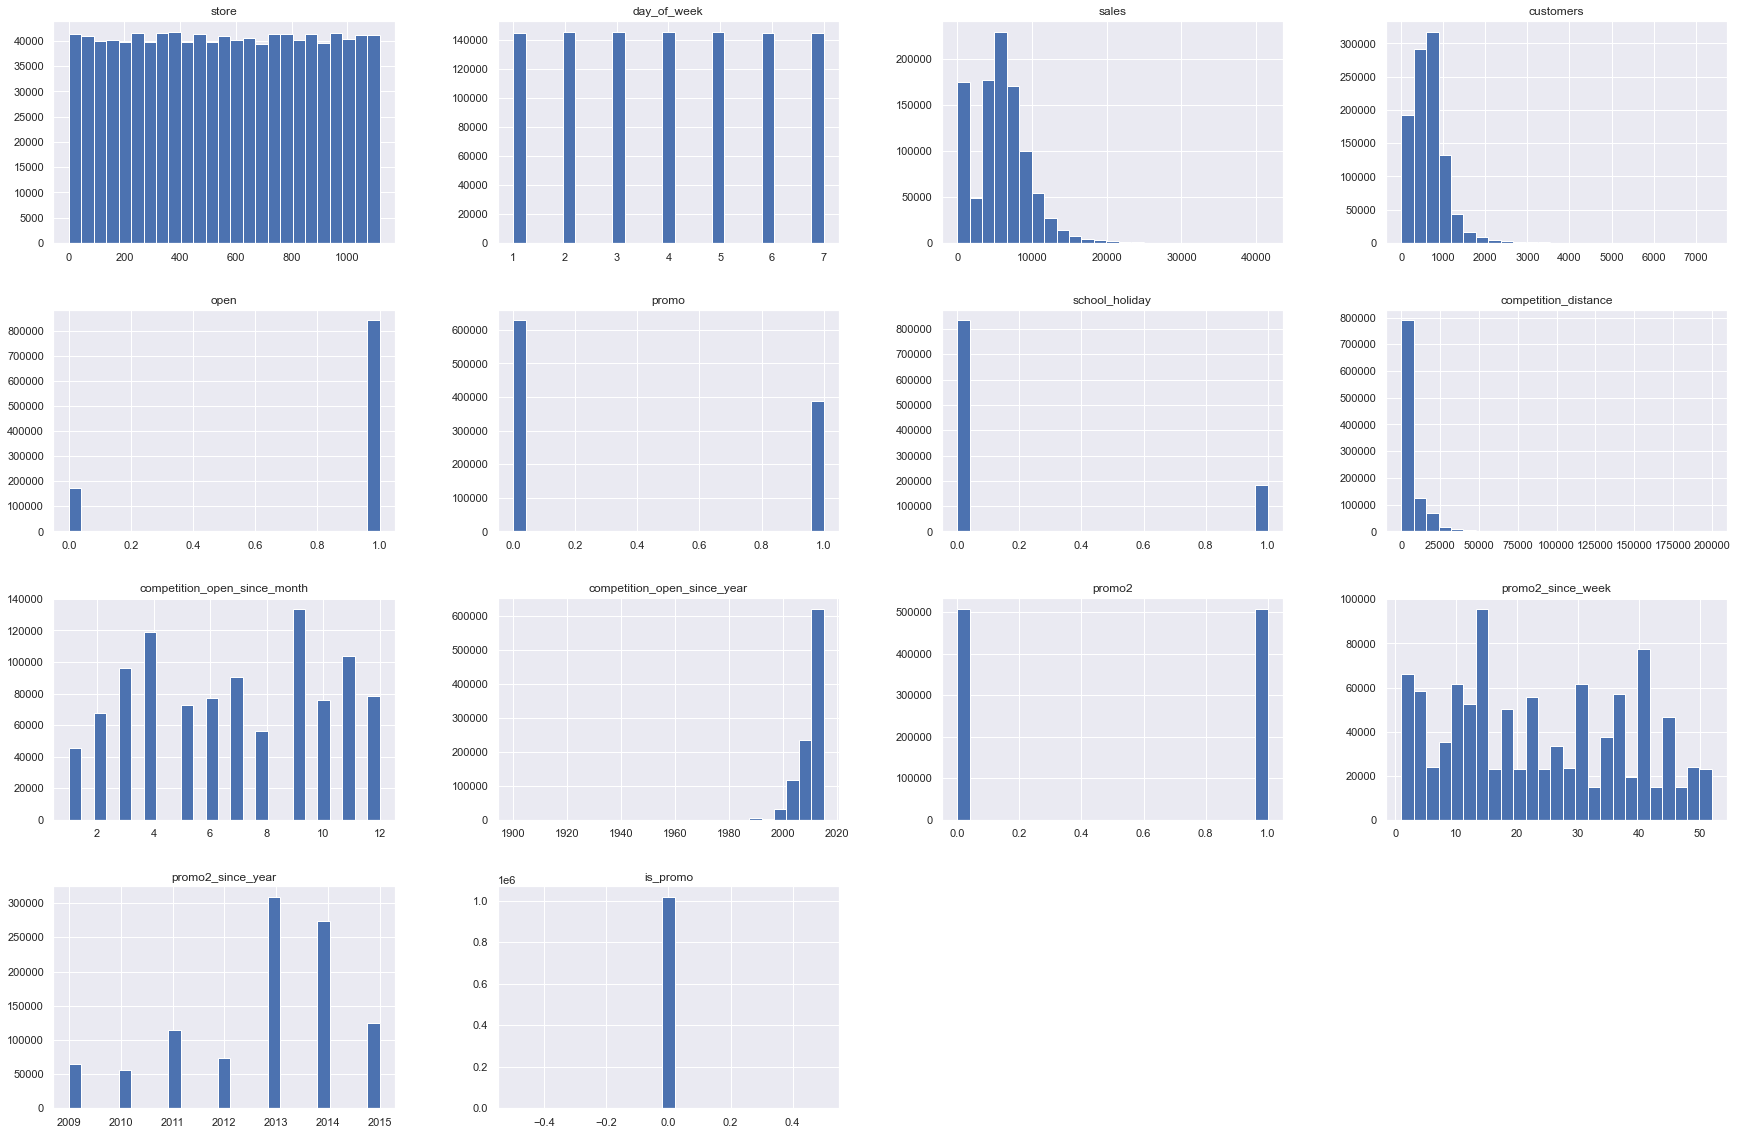

In [28]:
num_attributes.hist(figsize=(30,20), bins=25);

### 4.1.3 Categorical Variables

In [44]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

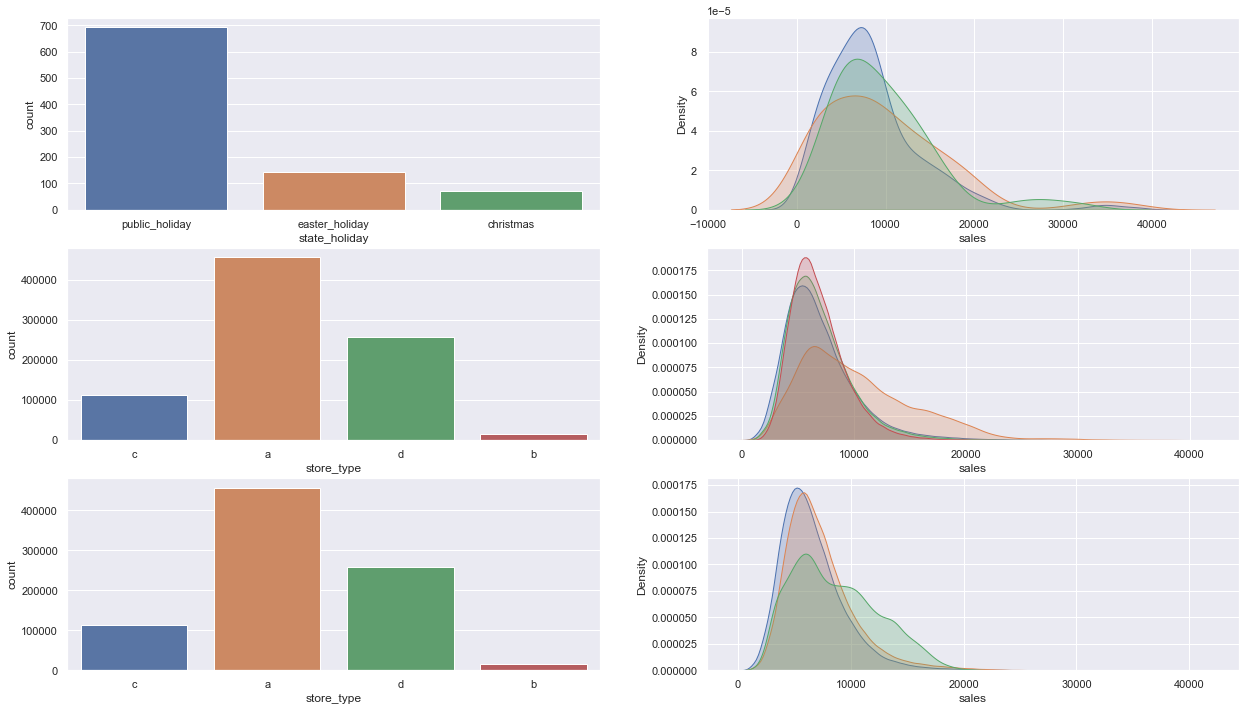

In [29]:
#state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

#store type
plt.subplot(3,2,3)
b = df4[df4['store_type'] != 'regular_day']
sns.countplot(b['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

#assortment
plt.subplot(3,2,5)
b = df4[df4['store_type'] != 'regular_day']
sns.countplot(b['store_type'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);


## 4.2 Bivariate Analysis

### H1: Stores with bigger assortment sell more
**True** Stores with bigger assortment sell more than the basic one

In [50]:
print('Extended: ' + str(len(df4[df4['assortment'] == 'extended'])))
print('Basic: ' + str(len(df4[df4['assortment'] == 'basic'])))
print('Extra: ' + str(len(df4[df4['assortment'] == 'extra'])))

Extended: 391254
Basic: 444875
Extra: 8209


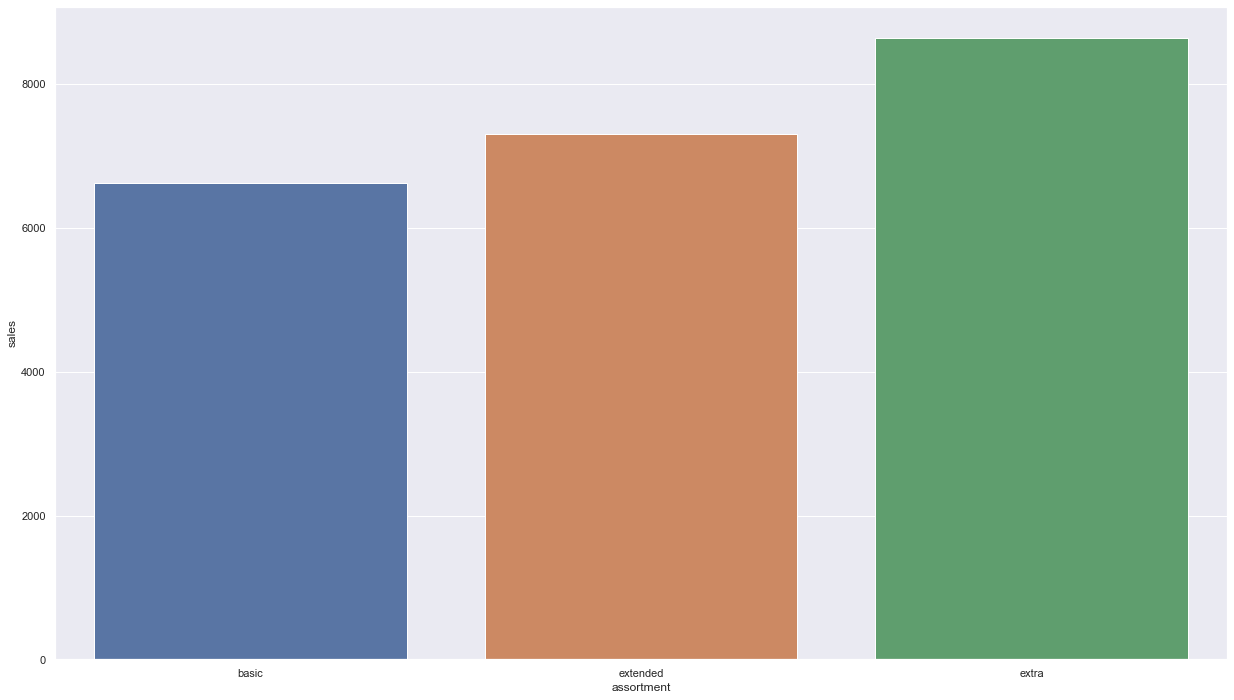

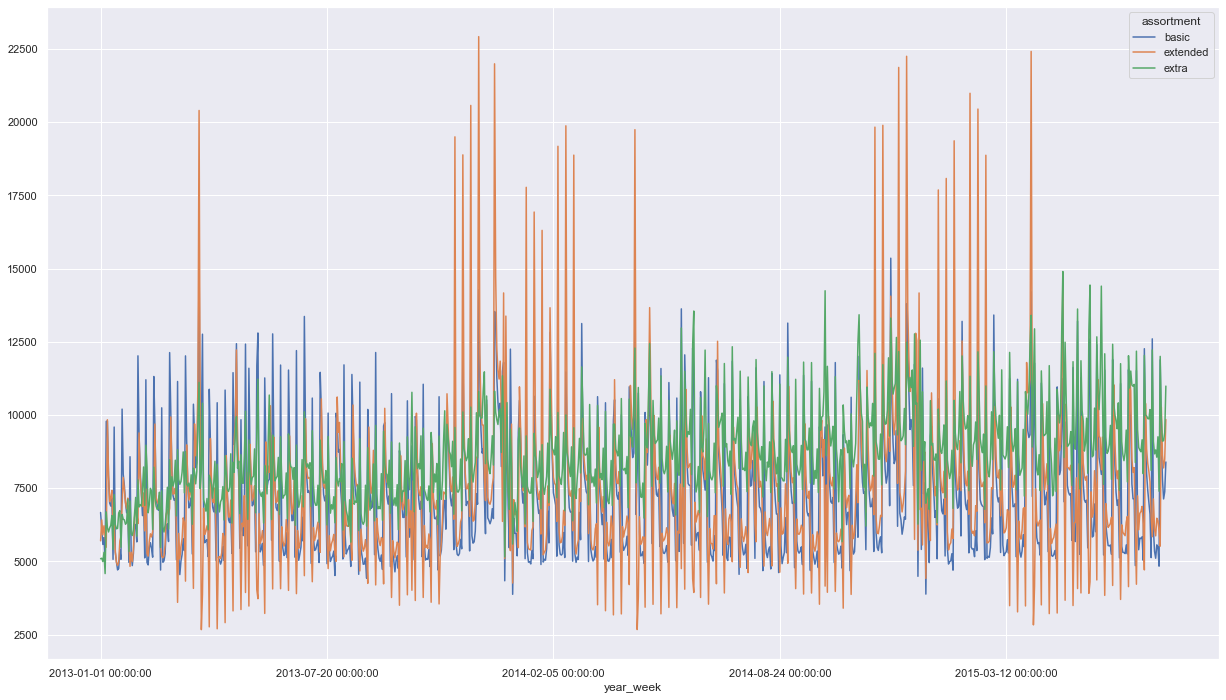

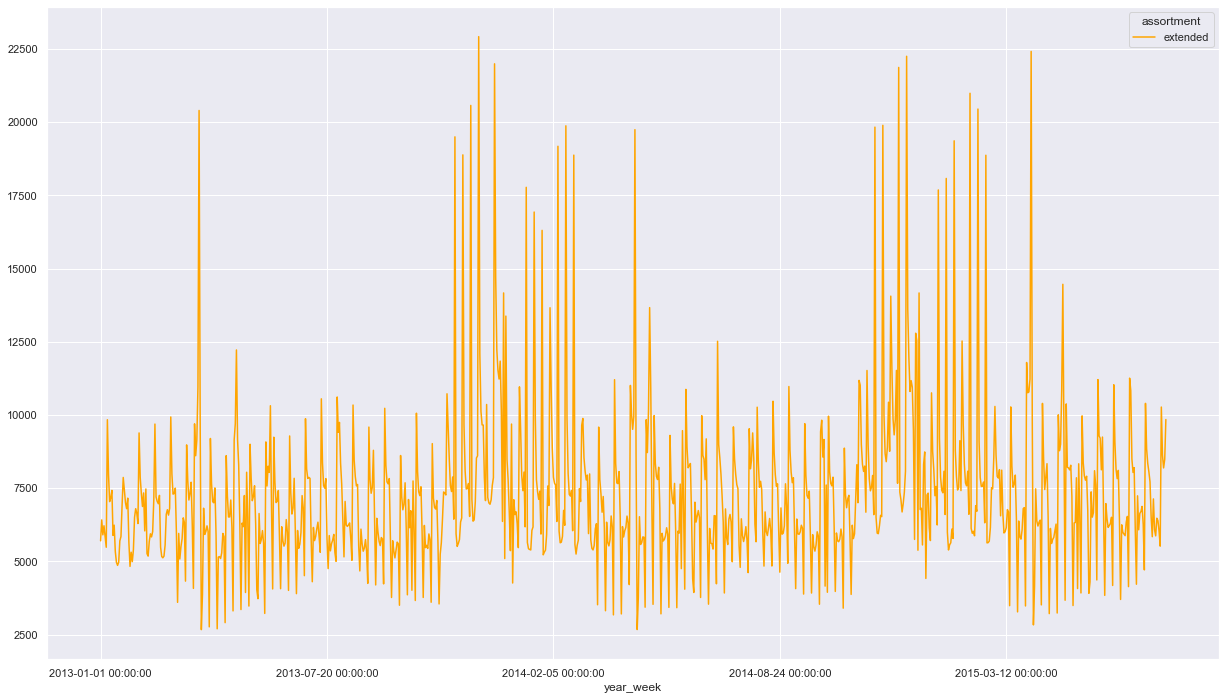

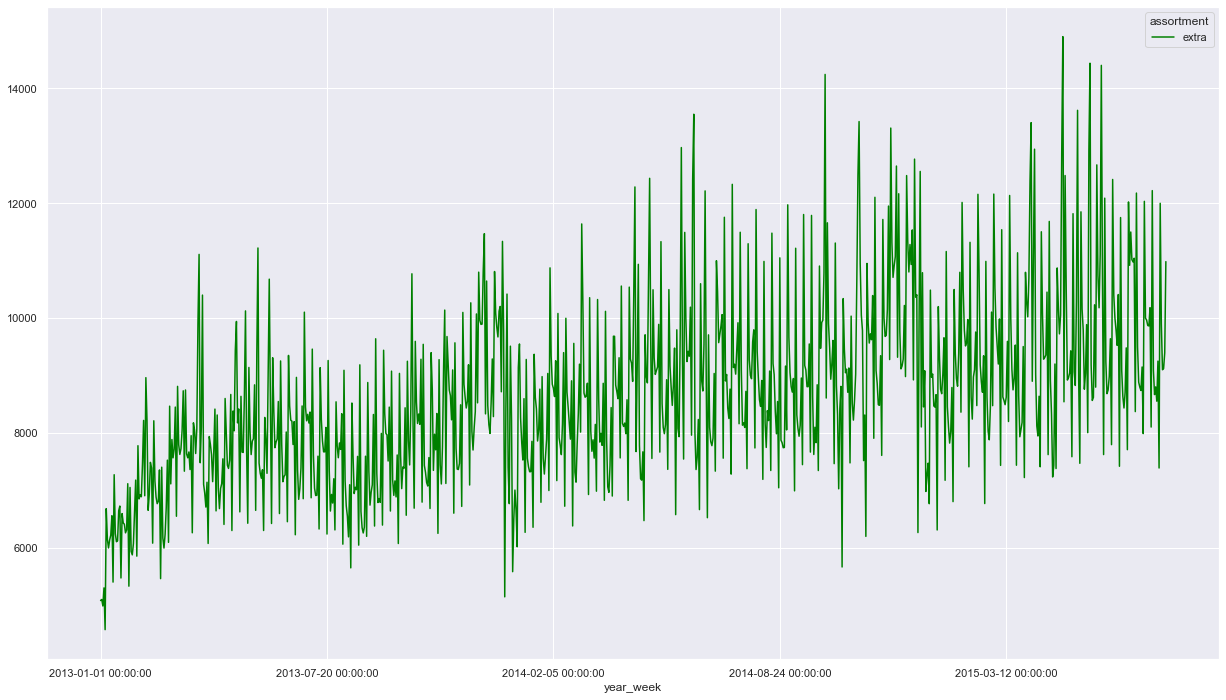

In [30]:
#grouping
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extended']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(color='orange');

aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week', columns='assortment', values='sales').plot(color='green');

### H2: Stores with closer competitors sell less
**FALSE** Stores with closer competition sell more

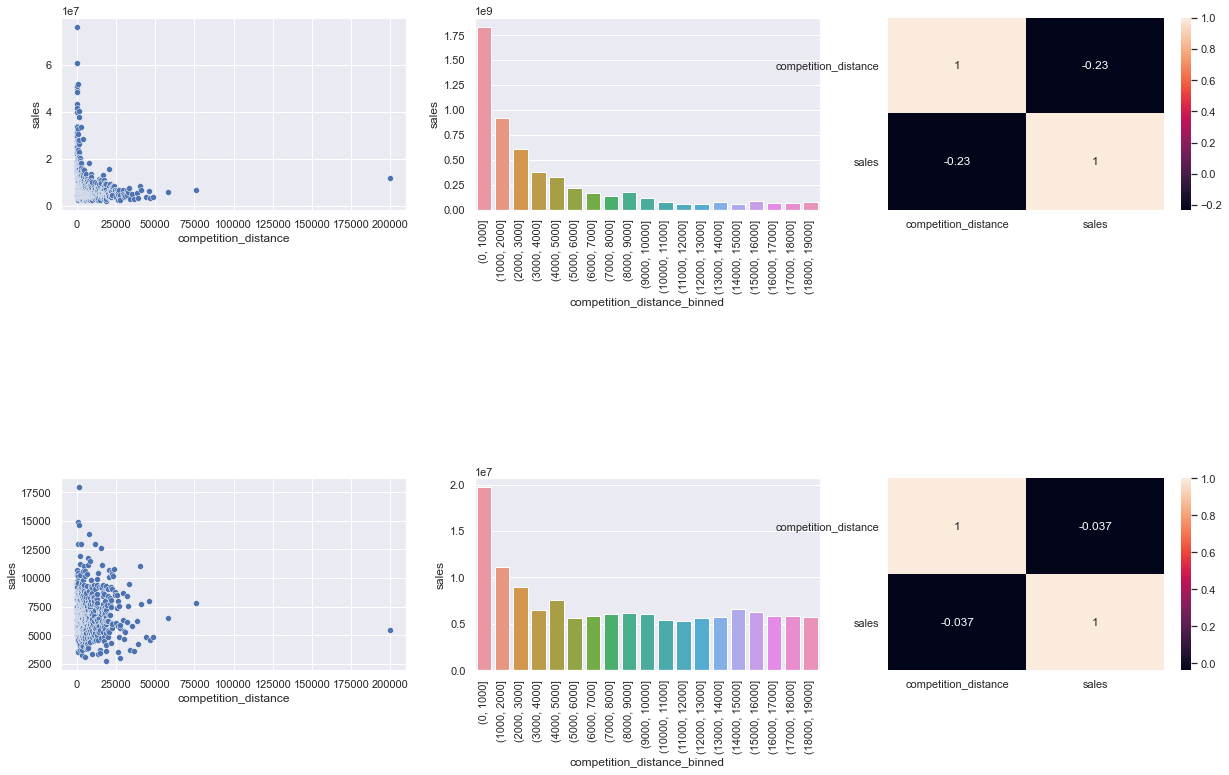

In [31]:
#sum based
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(x=aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

#mean based
aux3 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()

aux3['competition_distance_binned'] = pd.cut(x=aux1['competition_distance'], bins=bins)
aux4 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

#plot
#row1
plt.subplot(3,3,1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(3,3,2);
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(3,3,3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#row2
plt.subplot(3,3,7);
sns.scatterplot(x='competition_distance', y='sales', data=aux3);

plt.subplot(3,3,8);
sns.barplot(x='competition_distance_binned', y='sales', data=aux4);
plt.xticks(rotation=90)

plt.subplot(3,3,9);
sns.heatmap(aux3.corr(method='pearson'), annot=True);

### H3: Stores with competitors for longer sell more
**FALSE** Stores with competition for longer sell less

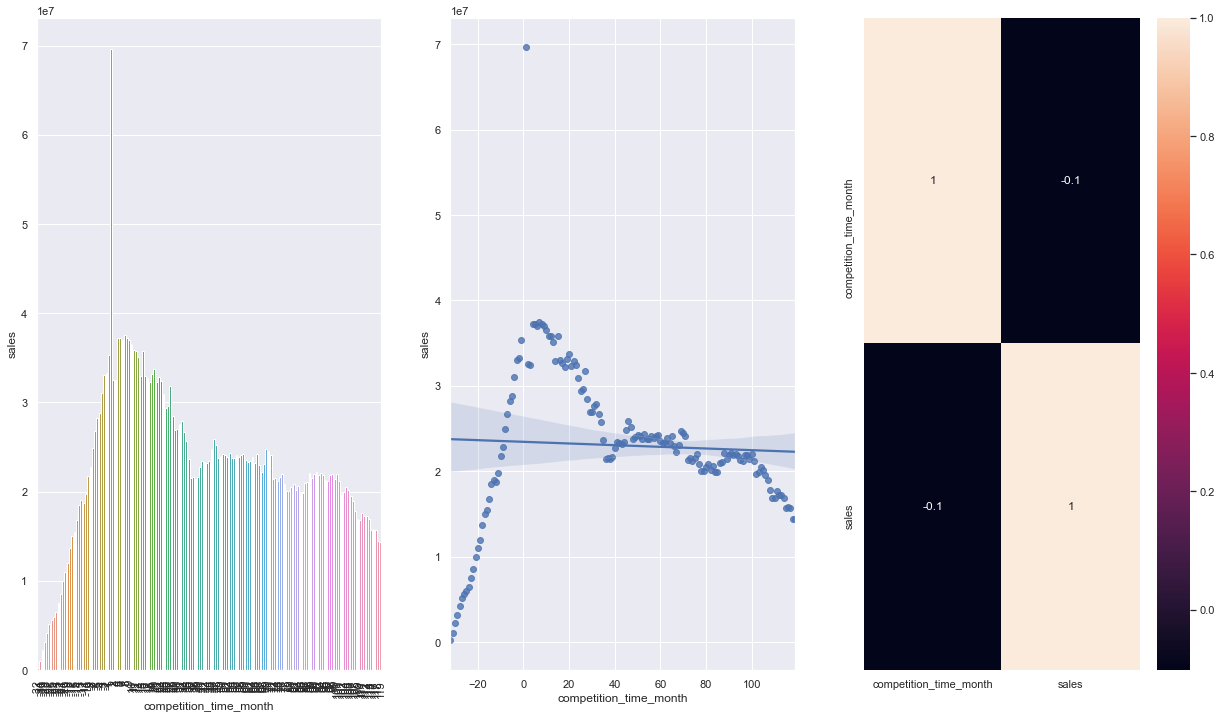

In [32]:
#filtering
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

#plot
plt.subplot(1,3,1);
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2);
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4: Stores with promo for longer sell more
**FALSE** Extended promo sell less

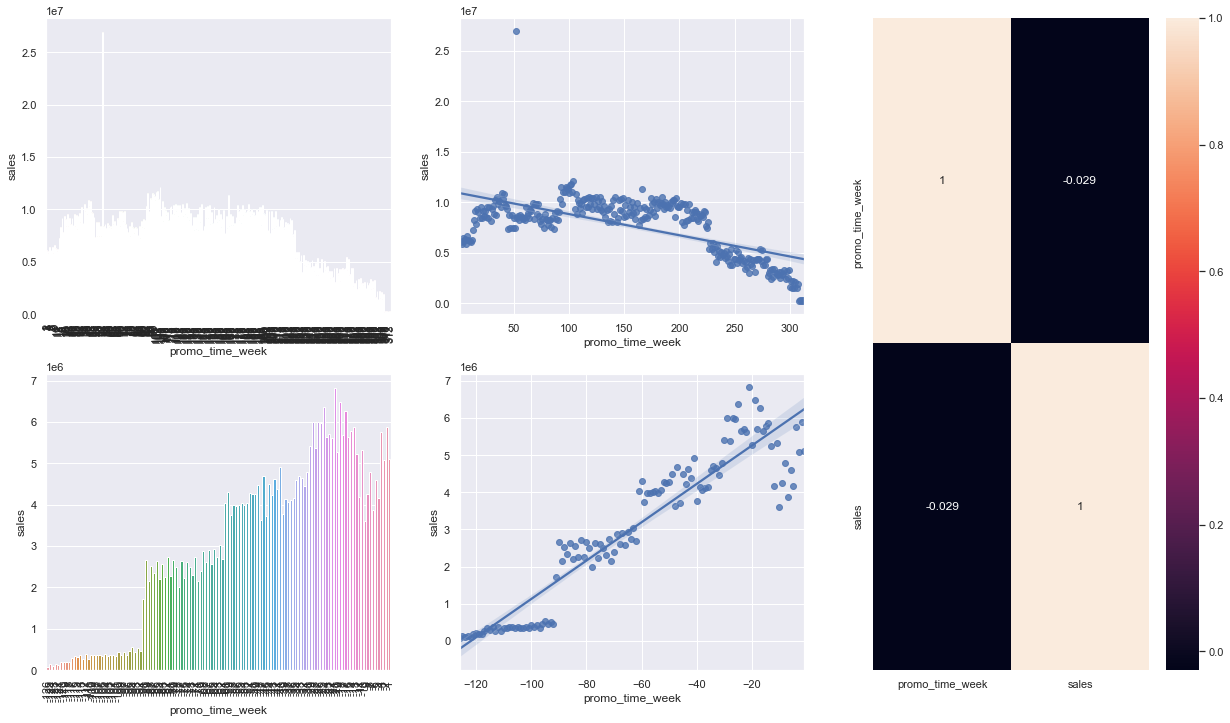

In [34]:
#grouping
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0] #promo2 (extended)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo (regular)

#plot

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0]);
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1]);
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0]);
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1]);
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2]);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5: Stores with more days of promo sell more<s>

### H6: Stores with consecutive promo sell more 
**False** Store with consecutive promo sell less

In [25]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


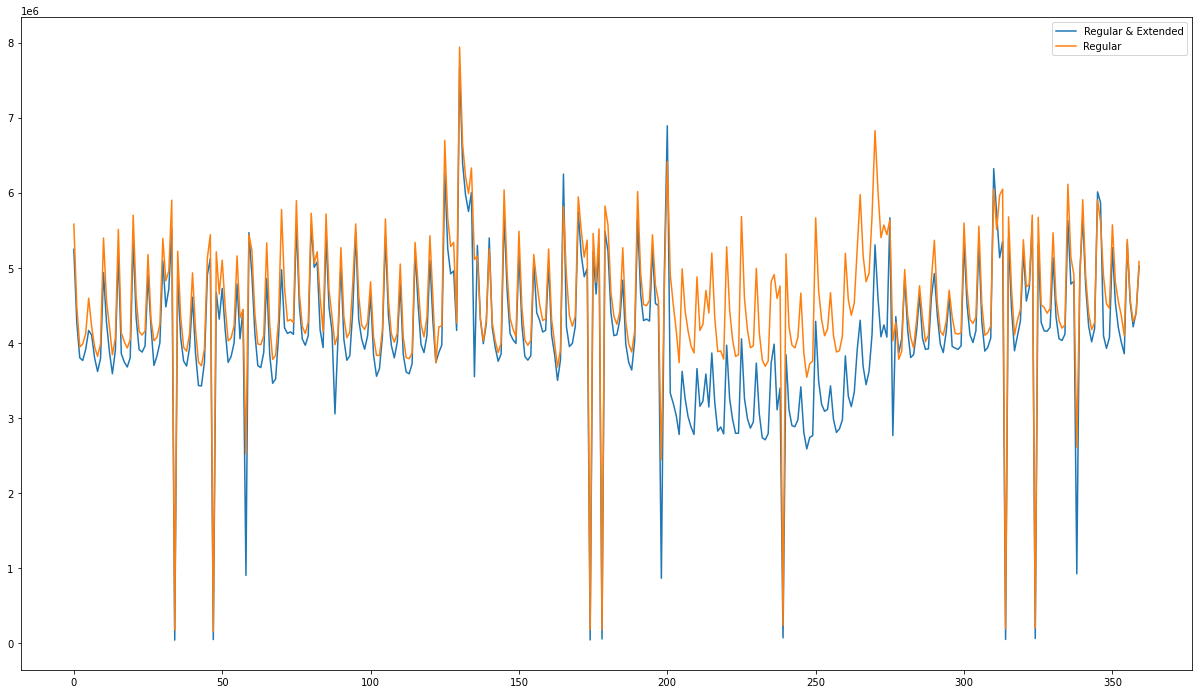

In [24]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Regular & Extended', 'Regular']);

### H7: Stores open at Chrismas sell more 
**True** In average, Stores sell more at Christmas

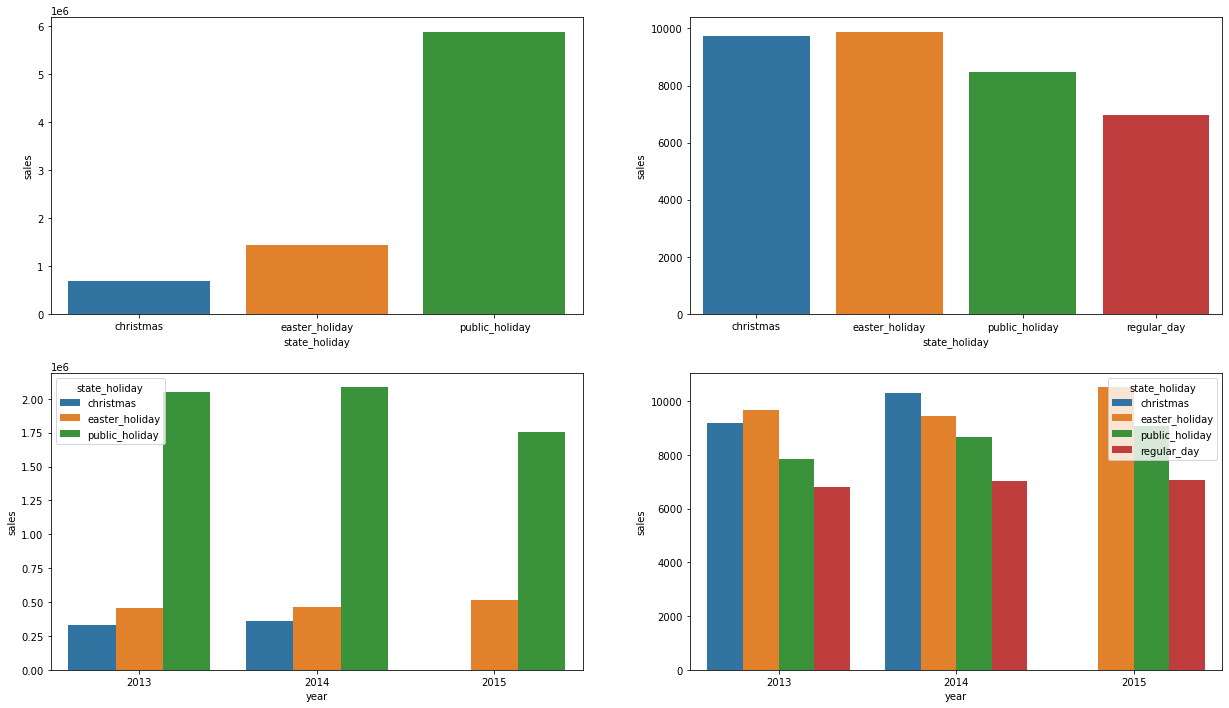

In [35]:
#filter
aux1 = df4[df4['state_holiday'] != 'regular_day']

aux2 = aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
aux3 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

#by year
aux4 = aux1[['year','state_holiday','sales']].groupby(['state_holiday', 'year']).sum().reset_index()
aux5 = df4[['year','state_holiday','sales']].groupby(['state_holiday', 'year']).mean().reset_index()

#plot
plt.subplot(2,2,1);
sns.barplot(x='state_holiday', y='sales', data=aux2);

plt.subplot(2,2,2);
sns.barplot(x='state_holiday', y='sales', data=aux3);

plt.subplot(2,2,3);
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux4);

plt.subplot(2,2,4);
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux5);

### H8: Stores sell more within the years
**False** Stores sell less within the years

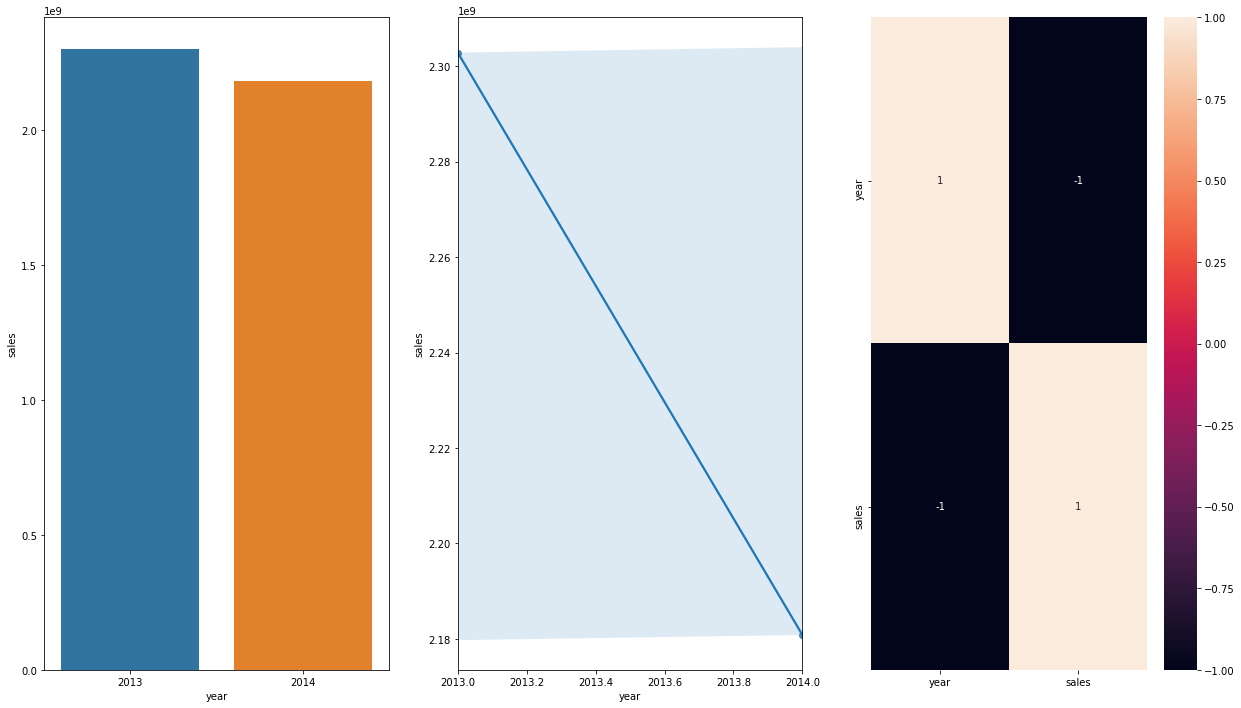

In [43]:
#filter
aux1 = df4[df4['year'] != 2015]
aux2 = aux1[['year', 'sales']].groupby('year').sum().reset_index()

#plot
plt.subplot(1,3,1);
sns.barplot(x='year', y='sales', data=aux2);

plt.subplot(1,3,2);
sns.regplot(x='year', y='sales', data=aux2);

plt.subplot(1,3,3);
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H9: Stores sell more in the second semester
**True** Stores sell more in the second semester

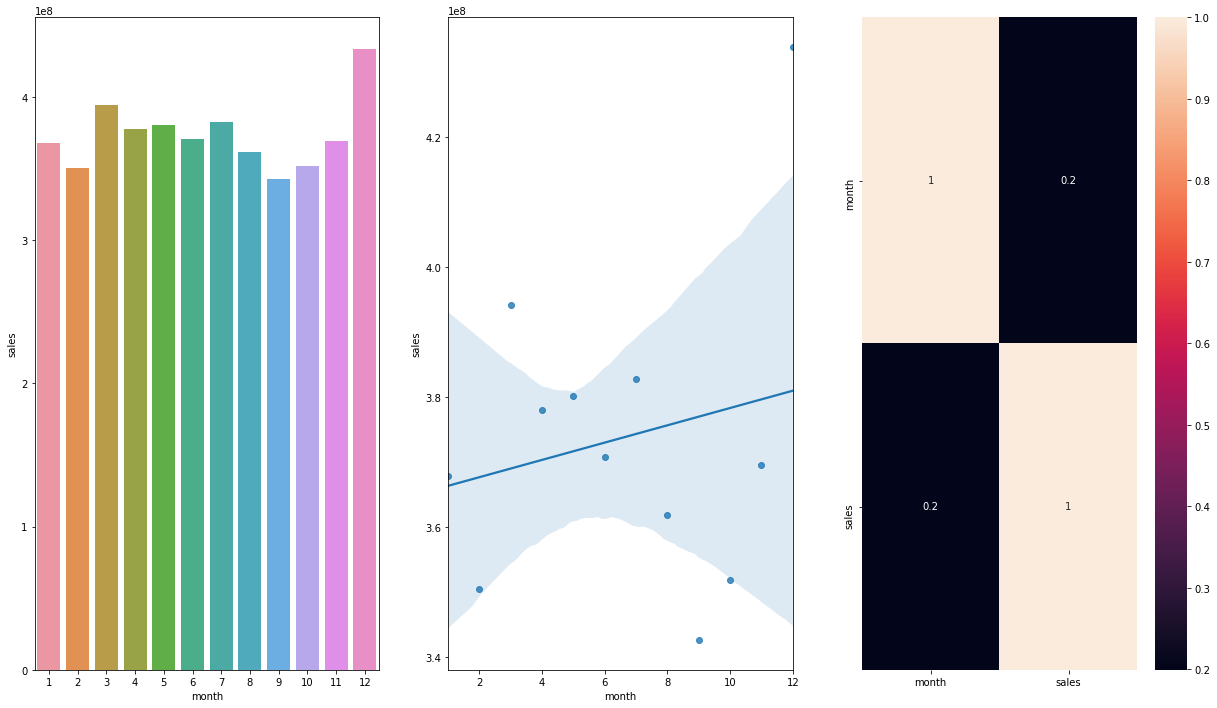

In [44]:
#filter
aux1 = df4[df4['year'] != 2015]
aux2 = aux1[['month', 'sales']].groupby('month').sum().reset_index()

#plot
plt.subplot(1,3,1);
sns.barplot(x='month', y='sales', data=aux2);

plt.subplot(1,3,2);
sns.regplot(x='month', y='sales', data=aux2);

plt.subplot(1,3,3);
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H10: Stores sell more after day 10th of the month
**True** Stores sell more after day 10

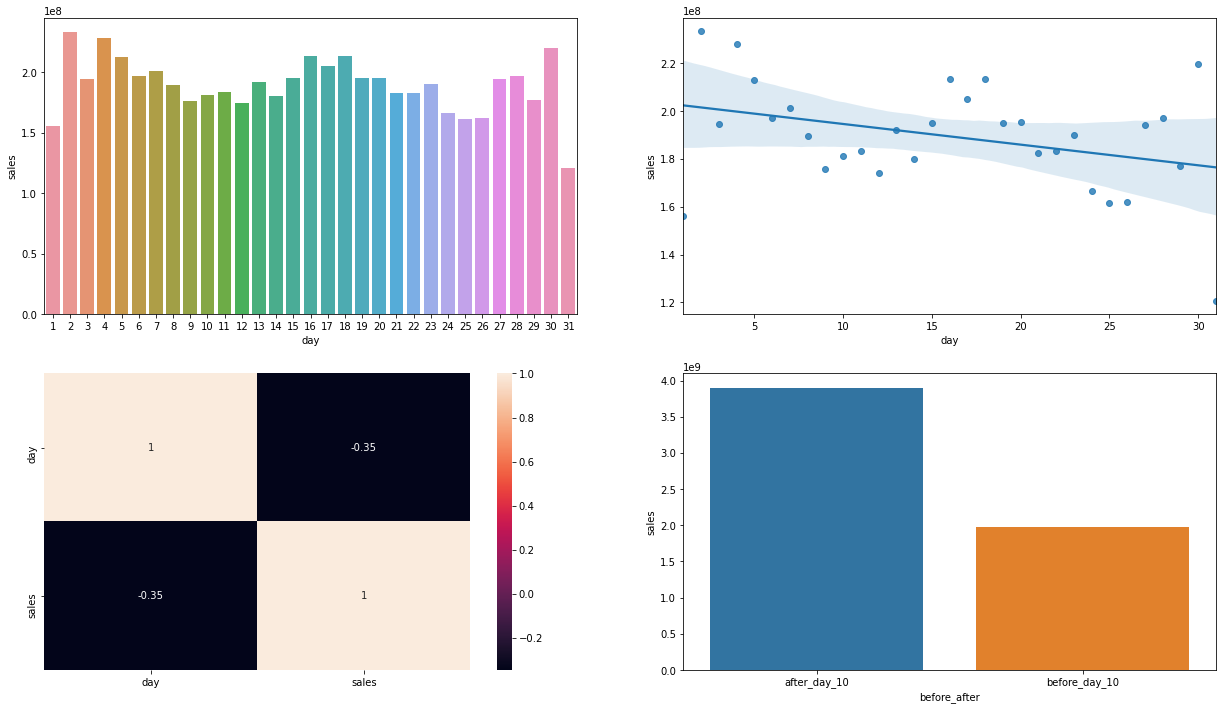

In [50]:
#create a new column
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1.day.apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

#plot
plt.subplot(2,2,1);
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2);
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4);
sns.barplot(x='before_after', y='sales', data=aux2);

### H11: Stores sell less on weekends
**True** Stores sell less on weekends

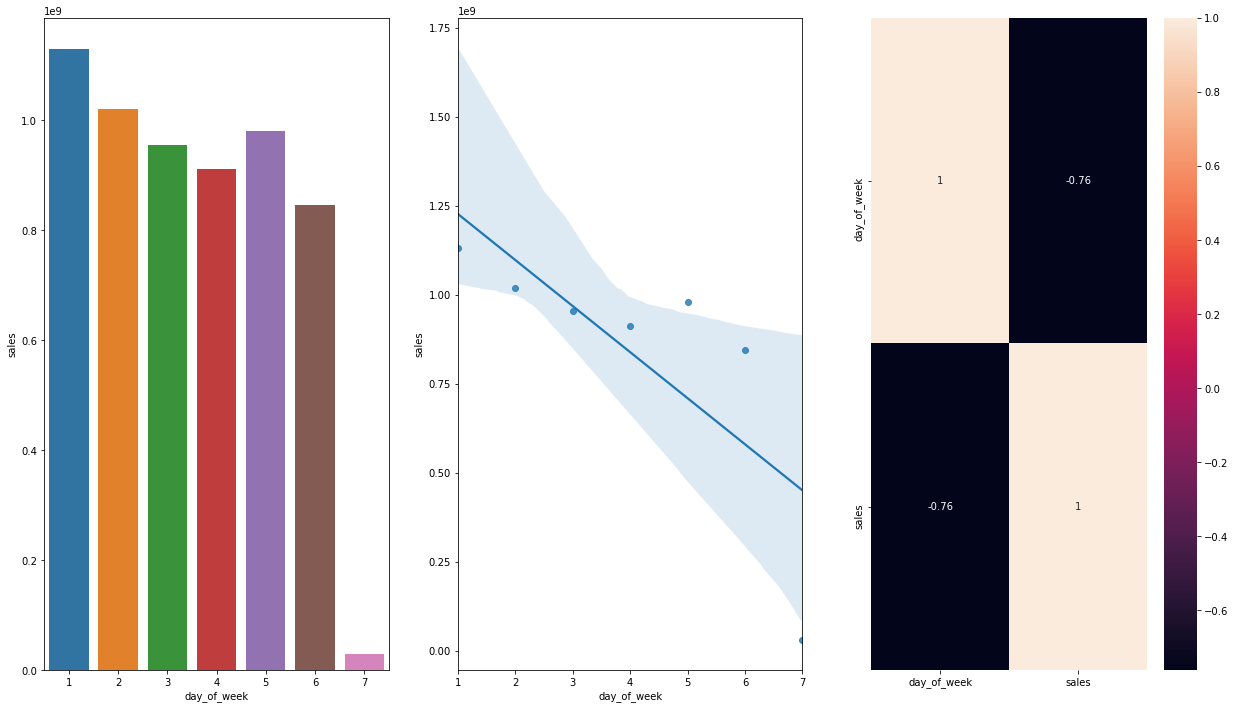

In [51]:
#filter
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

#plot
plt.subplot(1,3,1);
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2);
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12: Stores sell less on school holidays
**True** Stores sell less on school holidays, except in July and August

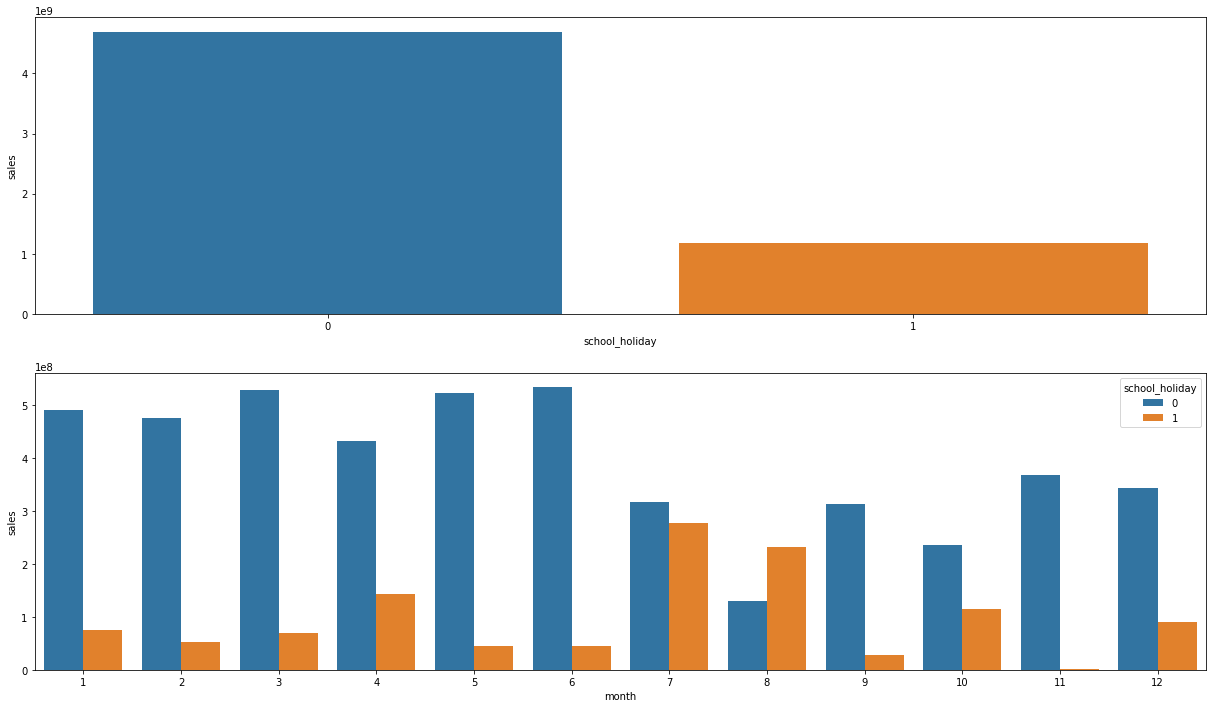

In [53]:
#group
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday', 'sales']].groupby(['school_holiday','month']).sum().reset_index()

#plot
plt.subplot(2,1,1);
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2);
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### Hypothesis Summary

In [29]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'True', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'True', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low']]


print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            True          Medium
H8            False         High
H9            True          High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes Correlation

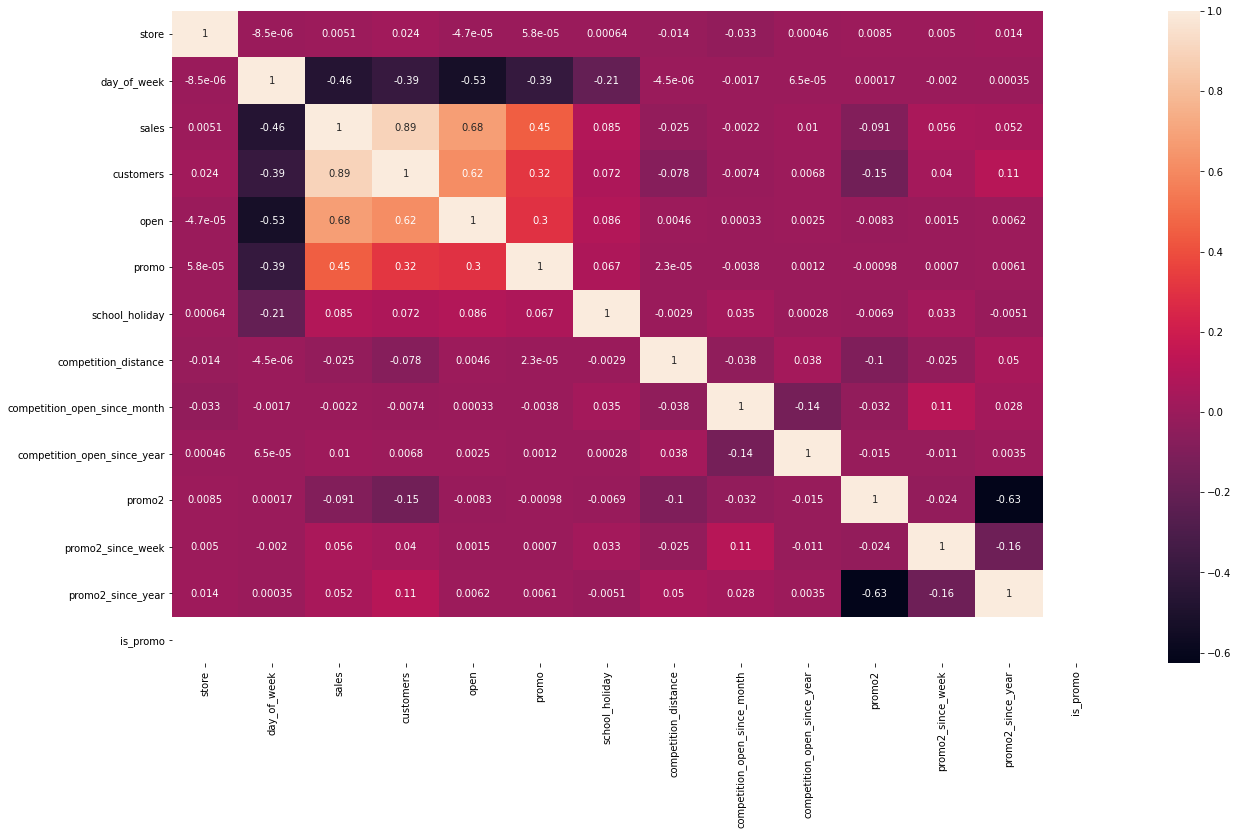

In [30]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes Correlation

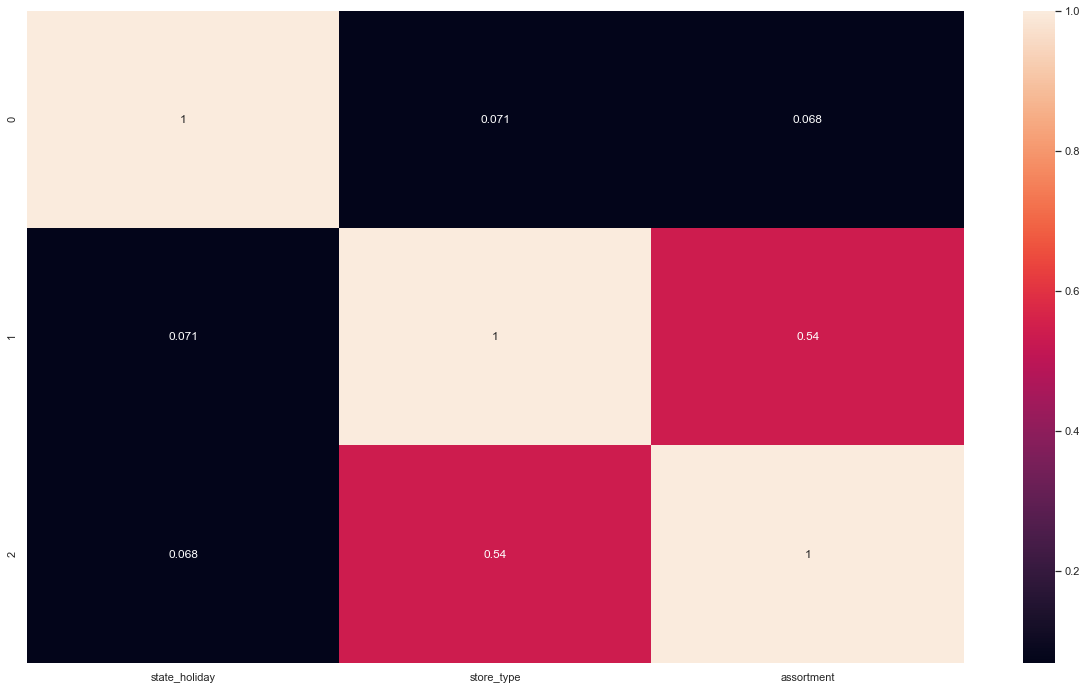

In [54]:
#selecting attributes
a = df4.select_dtypes(include='object')

#all options
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':(a1,a2,a3),
             'store_type':(a4,a5,a6),
             'assortment':(a7,a8,a9)})


#plot
sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [36]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescalling

In [43]:
#equations
rc = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rc.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rc.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


#year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3 Transformation

### 5.3.1 Encoding

In [45]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Nature Transformation

In [58]:
#sales
df5['sales'] = np.log1p(df5['sales'])

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. *np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. *np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))